# Neurosymbolic Software Tutorial - Regression - Solutions w/NEAR Interface

<a target="_blank" href="https://colab.research.google.com/github/kavigupta/neurosym-lib/blob/main/tutorial/near_demo_regression_solutions_interface.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Instruction
- Navigating this notebook on Google Colab: There will be text blocks and code blocks throughout the notebook. The text blocks, such as this one, will contain instructions and questions for you to consider. The code blocks, such as the one below, will contain executable code. Sometimes you will have to modify the code blocks following the instructions in the text blocks. You can run the code block by either pressing control/cmd + enter or by clicking the arrow on left-hand side as shown. `@TODO`
- Saving Work: If you wish to save your work in this .ipynb, we recommend downloading the compressed repository from GitHub, unzipping it, uploading it to Google Drive, and opening this notebook from within Google Drive.



## Outline
- Part 1: Data Exploration
    - We're going to define a function `datagen()` and plot trajectories generated with datagen.
    - **Exercise**: Before reading through the code, look at the trajectory plot and hypothesize what the underlying function might be. Write down what mathematical operators (`sin`, `pow`, `exp`, etc.) would be useful to discover the underlying function.
- Part 2: DSL Generation
    - We're going to formalize our intuition by writing a DSL. Write code for the DSL.
    - **Exercise**: Modify the DSL with the mathematical operators we wrote down earlier. 
- Part 3: Program Generation
    - We're going to use Neural guided search (NEAR) to search for the best-fit program in the DSL.
- Part 4: Program Inspection
    - We will render the program found by NEAR and inspect it's performance. 
    - **Exercise**: Inspect the program found after search. Try different hyperparamters.

## Part 1: Data Exploration
- Cell 1: Define `datagen()` and save data.
- Cell 2: Plot the saved data.
- Cell 3: Exercise

In [1]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
IS_REGRESSION = True
def datagen(B, T, *, seed, is_regression=False):
    rng = np.random.RandomState(seed)
    # generates a numpy trajectory of shape
    #   X = (B, T, d_inp)
    # and a numpy target of shape
    #   Y = (B, T, 1)
    X = rng.rand(B, T, 2)

    X[:, 0, :] = 0
    for t in range(1, T):
        step = rng.randn(B, 2) * 0.2
        X[:, t, :] = X[:, t-1, :] + step
    X = X.astype(np.float32)

    # normalize X b/w -1 and 1
    X = (X - np.min(X)) / (np.max(X) - np.min(X))
    X = (X - 0.5) * 2

    if is_regression:
        # # y = distance from origin of X
        # Y = np.zeros((B, T, 1))
        # Y = np.linalg.norm(X, axis=2, keepdims=True)
        # Y = Y.reshape(-1, T, 1)
        # Y = Y.astype(np.float32)

        Y = abs(X[:, :, 0]).reshape(B, T, 1)
        # for all values of X > 0, y *= 10 else y *= -10
        Y = np.where(X[:, :, 0:1] > 0, Y * 2, Y * 0.5)
    else:
        # y = quadrant of X
        Y = np.zeros((B, T), dtype=int)
        for i in range(B):
            for j in range(T):
                x, y = X[i, j, :]
                if x > 0 and y > 0:
                    Y[i, j] = 0
                elif x < 0 and y > 0:
                    Y[i, j] = 0
                elif x < 0 and y < 0:
                    Y[i, j] = 1
                else: # x > 0 and y < 0
                    Y[i, j] = 1
        Y = Y.reshape(B, T, 1)

    return X, Y

X_train, y_train = datagen(1000, 10, is_regression=IS_REGRESSION, seed=1)
X_test, y_test = datagen(50, 10, is_regression=IS_REGRESSION, seed=0)
# save data
os.makedirs('../data/regression_example/', exist_ok=True)
np.save('../data/regression_example/train_ex_data.npy', X_train)
np.save('../data/regression_example/train_ex_labels.npy', y_train)
np.save('../data/regression_example/test_ex_data.npy', X_test)
np.save('../data/regression_example/test_ex_labels.npy', y_test)


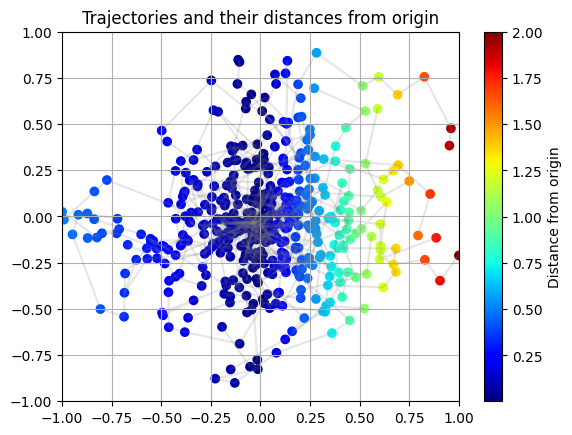

In [2]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import Normalize

def plot_trajectory(X, Y, is_regression=False):
    B, T, _ = X.shape
    
    if is_regression:
        cmap_name = 'jet'
        colorbar_label = "Distance from origin"
        title = "Trajectories and their distances from origin"
        norm = Normalize(vmin=Y.min(), vmax=Y.max())
    else:
        cmap_name = 'jet'
        colorbar_label = "Quadrant"
        title = "Trajectories and their quadrants"
        norm = Normalize(vmin=Y.min(), vmax=Y.max())
    
    for b in range(B):
        trajectory = X[b]
        output = Y[b].squeeze()

        plt.scatter(trajectory[:, 0], trajectory[:, 1], c=output, marker='o', cmap=cmap_name, norm=norm)
        
        plt.plot(trajectory[:, 0], trajectory[:, 1], alpha=0.2, color='gray')
    
    plt.colorbar(label=colorbar_label)
    plt.title(title)
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.grid(True)
    plt.show()

# Hope its clear that we are trying to predict the distance from origin
plot_trajectory(X_test, y_test, is_regression=IS_REGRESSION)


### Exercise

*Observe the scatterplot above. Hypothesize what underlying function would allow us to generate this data. Concretely, write down the mathematical operators (`sin`, `pow`, `exp`, etc.) that would be useful to discover the underlying function.*


<details>
  <summary>Spoiler! Click to see the answer!</summary>
  y increases linearly with abs(X). Also, the rate of increase of y is higher for X > 0 than for X <= 0.
</details>

Some useful operators are:
- `mul: (np.array, np.array) -> (np.array)`: Return elementwise multiplication of two arrays of same shape.
- `@TODO`

## Part 2: DSL Generation
- Cell 1: Predefined DSL. 
    - Exercise: Augment the DSL with the operators you wrote down earlier. This is most likely the hardest part of this tutorial!

In [4]:
import torch
import torch.nn as nn

import neurosym as ns
from neurosym.examples import near

def simple_dsl(L, O):
    dslf = ns.DSLFactory(L=L, O=O, max_overall_depth=5)
    dslf.typedef("fL", "{f, $L}")

    # BEGIN SOLUTION "YOUR CODE HERE"
    # dslf.concrete("add", "() -> ($fL, $fL) -> $fL", lambda: lambda x, y: x + y)
    # dslf.concrete("mul", "() -> ($fL, $fL) -> $fL", lambda: lambda x, y: x * y)
    # dslf.concrete("fold", "((#a, #a) -> #a) -> [#a] -> #a", lambda f: lambda x: near.operations.fold_torch(f, x))
    dslf.concrete("sum", "() -> $fL -> {f, 1}", lambda: lambda x: torch.sum(x, dim=-1).unsqueeze(-1))

    dslf.parameterized("linear_bool", "() -> $fL -> {f, 1}", lambda lin: lin, dict(lin=lambda: nn.Linear(L, 1)))
    dslf.parameterized("linear", "() -> $fL -> $fL", lambda lin: lin, dict(lin=lambda: nn.Linear(L, L)))
    dslf.parameterized("output", "(([$fL]) -> [$fL]) -> [$fL] -> [{f, $O}]", lambda f, lin: lambda x: lin(f(x)), dict(lin=lambda: nn.Linear(L, O)))

    dslf.concrete("ite", "(#a -> {f, 1}, #a -> #a, #a -> #a) -> #a -> #a", lambda cond, fx, fy: near.operations.ite_torch(cond, fx, fy))
    dslf.concrete("map", "(#a -> #b) -> [#a] -> [#b]", lambda f: lambda x: near.operations.map_torch(f, x))
    # dslf.concrete("compose", "(#a -> #b, #b -> #c) -> #a -> #c", lambda f, g: lambda x: g(f(x)))
    # END SOLUTION
    
    dslf.prune_to("[{f, $L}] -> [{f, $O}]")
    return dslf.finalize()

dsl = simple_dsl(X_test.shape[-1], y_test.shape[-1])
print(dsl.render())

            sum :: () -> {f, 2} -> {f, 1}
            ite :: (#a -> {f, 1}, #a -> #a, #a -> #a) -> #a -> #a
            map :: (#a -> #b) -> [#a] -> [#b]
linear_bool[lin] :: () -> {f, 2} -> {f, 1}
    linear[lin] :: () -> {f, 2} -> {f, 2}
    output[lin] :: ([{f, 2}] -> [{f, 2}]) -> [{f, 2}] -> [{f, 1}]


### Exercise
*Augment the DSL above with the operators you wrote down earlier.*

## Part 3: Program Generation

We're going to use neural guided search to search for the program in the DSL that maximally fits the dataset.

- Cell 1: Define a pytorch dataset from the saved data.
- Cell 2: Define `neural_dsl`. This DSL extend the DSL we created with _neural modules_.
- Cell 3: Define optimization functions to train module parameters.
- Cell 4: Define a stopping condition for the search.
- Cell 5: Define the search space and initiate the search.

In [5]:
def dataset_factory(train_seed):
    return ns.DatasetWrapper(
        ns.DatasetFromNpy(
            "../data/regression_example/train_ex_data.npy",
            "../data/regression_example/train_ex_labels.npy",
            train_seed,
        ),
        ns.DatasetFromNpy(
            "../data/regression_example/test_ex_data.npy",
            "../data/regression_example/test_ex_labels.npy",
            None,
        ),
        batch_size=200,
    )


datamodule = dataset_factory(42)
input_dim, output_dim = datamodule.train.get_io_dims()
if IS_REGRESSION:
    output_dim = 1
print(input_dim, output_dim)

2 1


In [11]:
t = ns.TypeDefiner(L=input_dim, O=output_dim)
t.typedef("fL", "{f, $L}")
t.typedef("fO", "{f, $O}")


neural_modules={
    **near.create_modules(
        "mlp",
        [t("($fL) -> $fL"), t("($fL) -> $fO"), t("($fL) -> {f, 1}")],
        near.mlp_factory(hidden_size=10),
    ),
    **near.create_modules(
        "rnn_seq2seq",
        [t("([$fL]) -> [$fL]"), t("([$fL]) -> [$fO]"), t("([$fL]) -> [{f, 1}]")],
        near.rnn_factory_seq2seq(hidden_size=10),
    ),
    **near.create_modules(
        "rnn_seq2class",
        [t("([$fL]) -> $fL"), t("([$fL]) -> {f, 1}")],
        near.rnn_factory_seq2class(hidden_size=10)
    )
}


In [12]:
pl = ns.import_pytorch_lightning()
def regression_mse_loss(
    predictions: torch.Tensor, targets: torch.Tensor
) -> torch.Tensor:
    """
    Not used. Retained for reference for implementing a regression loss.
    """
    predictions = predictions.view(-1, predictions.shape[-1])
    targets = targets.view(-1, targets.shape[-1])
    return torch.nn.functional.mse_loss(predictions, targets)


def regression_smooth_l1_loss(
    predictions: torch.Tensor, targets: torch.Tensor
) -> torch.Tensor:
    """
    MSE loss is sensitive to outliers. Smooth L1 loss deals with outliers by
    using MSE loss when L1 distance is less than beta and a diminished 
    L1 loss otherwise.
    """
    # BEGIN SOLUTION "YOUR CODE HERE"
    predictions = predictions.view(-1, predictions.shape[-1])
    targets = targets.view(-1, targets.shape[-1])
    return torch.nn.functional.smooth_l1_loss(predictions, targets, beta=1.0)
    # END SOLUTION



In [13]:
# BEGIN SOLUTION # TODO: Instantiate the NEAR interface.
max_depth = 7
interface = near.NEAR(
    input_dim=input_dim,
    output_dim=output_dim,
    max_depth=max_depth,
    lr=1e-3,
    max_seq_len=100,
    n_epochs=30,
    accelerator="cpu",
)
# END SOLUTION

In [14]:
# BEGIN SOLUTION # TODO: Register the interface search parameters.
interface.register_search_params(
    dsl=dsl,
    type_env=t,
    neural_modules=neural_modules,
    search_strategy=ns.search.bounded_astar,
    loss_callback=regression_smooth_l1_loss
)

# END SOLUTION

In [25]:
# BEGIN SOLUTION # TODO: Find the top 4 programs for the dataset.
%load_ext autoreload
%autoreload 2

best_programs = interface.fit(
    datamodule=datamodule,
    program_signature="([{f, $L}]) -> [{f, $O}]",
    n_programs=4
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Training ??::<[{f, 2}] -> [{f, 1}]>
Epoch 29: 100%|██████████| 5/5 [00:00<00:00, 73.68it/s, train_loss=0.0213, val_loss=0.0751] 
Training (map ??::<{f, 2} -> {f, 1}>)
Epoch 29: 100%|██████████| 5/5 [00:00<00:00, 90.56it/s, train_loss=0.0352, val_loss=0.100] 
Training (output ??::<[{f, 2}] -> [{f, 2}]>)
Epoch 29: 100%|██████████| 5/5 [00:00<00:00, 84.90it/s, train_loss=0.0558, val_loss=0.139] 
Training (__neural_dsl_internal_rnn_seq2seq_2)
Epoch 29: 100%|██████████| 5/5 [00:00<00:00, 87.60it/s, train_loss=0.0196, val_loss=0.0809] 
Training (map (sum))
No parameters in program (map (sum))
Training (map (linear_bool))
Epoch 29: 100%|██████████| 5/5 [00:00<00:00, 126.35it/s, train_loss=0.104, val_loss=0.199] 
Training (map (__neural_dsl_internal_mlp_2))
Epoch 29: 100%|██████████| 5/5 [00:00<00:00, 85.35it/s, train_loss=0.0417, val_loss=0.0853] 
Training (map (linear_bool))
Epoch 29: 100%|██████████| 5/5

## Part 4: Program Inspection

A key benefit of program synthesis is that the output program is interpretable.

- Cell 1: Render the best program.
- Cell 2: Visualize the output space of the best program.
    - Exercise: Does the program discovered line up with your initial hypotheses?

In [27]:
# ns.render_s_expression(best_programs[0].initalized_program)


[TorchProgramModule(
   (contained_modules): ModuleList(
     (0-1): 2 x Linear(in_features=2, out_features=1, bias=True)
     (2-3): 2 x Linear(in_features=2, out_features=2, bias=True)
   )
 ),
 TorchProgramModule(
   (contained_modules): ModuleList(
     (0): Linear(in_features=2, out_features=1, bias=True)
   )
 ),
 TorchProgramModule(
   (contained_modules): ModuleList(
     (0): Linear(in_features=2, out_features=1, bias=True)
     (1): Linear(in_features=2, out_features=2, bias=True)
   )
 ),
 TorchProgramModule(
   (contained_modules): ModuleList(
     (0): Linear(in_features=2, out_features=1, bias=True)
     (1-2): 2 x Linear(in_features=2, out_features=2, bias=True)
   )
 )]

(output (map (ite (linear_bool) (linear) (linear))))


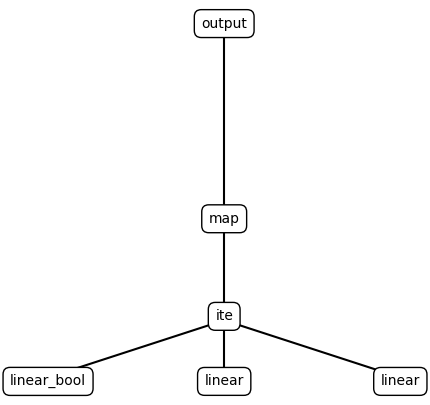

In [34]:
def plot_expression(sexpr, x=0.5, y=1, level=1, dx=0.1, ax=None, text_offset=0.02):
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.set_axis_off()

    ax.text(x, y, sexpr.symbol, ha='center', va='center',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

    num_children = len(sexpr.children)
    if num_children > 0:
        child_y = y - 1 / level
        for i, child in enumerate(sexpr.children):
            child_x = x - (dx * (num_children - 1) / 2) + i * dx
            ax.plot([x, child_x], [y - text_offset, child_y + text_offset], 'k-')
            plot_expression(child, x=child_x, y=child_y, level=level + 1, dx=dx / 2, ax=ax, text_offset=text_offset)

    if ax is None:
        plt.show()

best_program = interface.programs[0].program
print(ns.render_s_expression(best_program))
plot_expression(best_program)

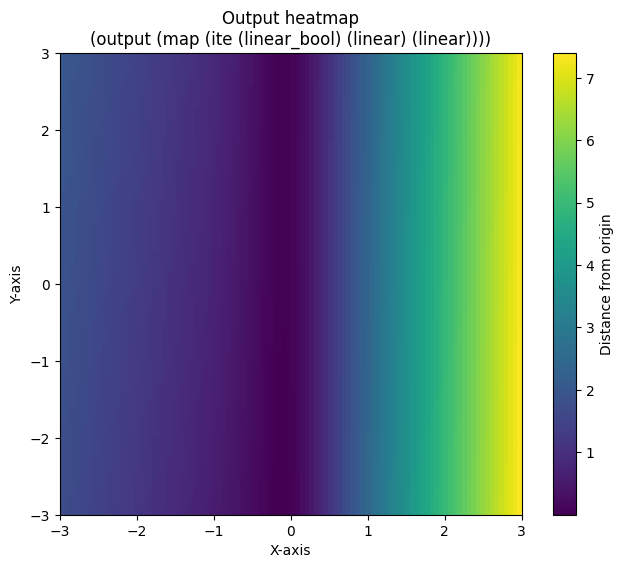

In [36]:
grid = np.linspace(-3, 3, 100)
xx, yy = np.meshgrid(grid, grid)

X = np.stack([xx, yy], axis=-1)
X = X.reshape(-1, 2)    
X = torch.tensor(X, dtype=torch.float32)
Y = interface.programs[0](X.unsqueeze(0)).squeeze(0)
Y = Y.detach().numpy()
Y = Y.reshape(100, 100, 1)
y = Y
# Using imshow to plot y as a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(y, origin='lower', extent=(-3, 3, -3, 3), cmap='viridis')
plt.colorbar(label="Distance from origin")
plt.title("Output heatmap\n{program}".format(program=ns.render_s_expression(interface.programs[0].program)))
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()


Notice that the output heatmap plots program output within the range `[-3, 3]` while the data we trained on was within the range `[-1, 1]`.

### Exercise
*Does the output heatmap line up with the trajectory data we visualized in part 1? Does the program and the heatmap line up with our initial hypotheses?*